In [1]:
import pandas as pd
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
equity_list = ['A', 'B']
alpha_1 = pd.Series(index=equity_list, data=[2.4, 2.5])
alpha_2 = pd.Series(index=equity_list, data=[2.5, 2.4])
benchmark_weight = pd.Series(index=equity_list, data=[0.5, 0.5])

sigma_A, sigma_B = 0.42, 0.33
rho_AB = 0.7
cov_mat = [
    [sigma_A ** 2, rho_AB * sigma_A * sigma_B],
    [rho_AB * sigma_A * sigma_B, sigma_B ** 2]
]
cov_df = pd.DataFrame(index=equity_list, columns=equity_list, data=cov_mat)
print(alpha_1, alpha_2, cov_df)

A    2.4
B    2.5
dtype: float64 A    2.5
B    2.4
dtype: float64          A        B
A  0.17640  0.09702
B  0.09702  0.10890


In [3]:
# alpha和cov扩展ｃａｓｈ
alpha_1['cash'] = 0.
alpha_2['cash'] = 0.
cov_df = cov_df.reindex(equity_list + ['cash']).fillna(0.)
cov_df['cash'] = 0.
trading_day = '20100101'
cov_panel = pd.Panel(
    data={trading_day: cov_df})
alpha_1_df = pd.DataFrame(
    index=[trading_day],
    data=[alpha_1])
alpha_2_df = pd.DataFrame(
    index=[trading_day],
    data=[alpha_2])

# benchmark
benchmark_weight['cash'] = 0.

asset_lower_boundary_series = pd.Series(index=equity_list, data=0.)
asset_lower_boundary_series['cash'] = 0
asset_upper_boundary_series = pd.Series(index=equity_list, data=1)
asset_upper_boundary_series['cash'] = 0.

/home/casey/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
from src.solver import *

In [5]:
market_value = 1.
current_price = pd.Series(index=equity_list+['cash'], data=1.)

target_risk = 0.10
target_return = 0.1


param = {
    'asset_list': equity_list,
    'alpha_series': alpha_2,
    'asset_ret_cov': cov_df,
    'market_value': market_value,
    'current_price': current_price,
    'benchmark_weight_series': benchmark_weight,
    'asset_lower_boundary_series': asset_lower_boundary_series,
    'asset_upper_boundary_series': asset_upper_boundary_series,
    'target_risk': target_risk,
    'target_return': target_return,
    'solver': cvx.MOSEK,
    'cash_position': 0.2
}

In [6]:
# param['asset_lower_boundary_series']['cash'] = param['cash_position']
# param['asset_upper_boundary_series']['cash'] = param['cash_position']
# model = MaxSharpeRatioSolver(param)
# model.solve_without_round()

In [7]:
# model = MaxReturnSolver(param)
# model.solve_without_round()

In [8]:
# model = MinRiskSolver(param)
# model.solve_without_round()

In [9]:
from src.efficient_frontier import *

In [10]:
eff_front = EfficientFrontier(param)
opt_list = eff_front.get_efficient_frontier()

A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer

  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 5
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables       : 7                 conic                  : 4               
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0



Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 5.1337351812e-04    nrm: 2e+00    Viol.  con: 2e-08    var: 0e+00    cones: 0e+00  
  Dual.    obj: 5.1334337294e-04    nrm: 3e-01    Viol.  con: 3e-09    var: 3e-08    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15    

Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 2.0533295484e-03    nrm: 2e+00    Viol.  con: 4e-08    var: 0e+00    cones: 0e+00  
  Dual.    obj: 2.0533195172e-03    nrm: 7e-01    Viol.  con: 4e-14    var: 1e-08    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization probl

Optimizer terminated. Time: 0.05    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 4.6200011994e-03    nrm: 2e+00    Viol.  con: 2e-10    var: 0e+00    cones: 0e+00  
  Dual.    obj: 4.6200007895e-03    nrm: 1e+00    Viol.  con: 2e-10    var: 2e-10    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization probl

6   1.7e-07  1.3e-07  5.7e-04  1.00e+00   8.213191830e-03   8.213072793e-03   1.3e-07  0.11  
7   2.0e-08  1.5e-08  1.9e-04  1.00e+00   8.213314110e-03   8.213300317e-03   1.5e-08  0.11  
Optimizer terminated. Time: 0.14    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 8.2133141104e-03    nrm: 2e+00    Viol.  con: 7e-08    var: 0e+00    cones: 0e+00  
  Dual.    obj: 8.2133003171e-03    nrm: 1e+00    Viol.  con: 7e-13    var: 2e-08    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0  

5   5.1e-06  3.9e-06  3.6e-03  1.08e+00   1.283817531e-02   1.283194055e-02   3.9e-06  0.04  
6   1.4e-08  1.0e-08  1.9e-04  1.00e+00   1.283334480e-02   1.283332747e-02   1.0e-08  0.04  
Optimizer terminated. Time: 0.07    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 1.2833344798e-02    nrm: 2e+00    Viol.  con: 1e-08    var: 0e+00    cones: 0e+00  
  Dual.    obj: 1.2833327469e-02    nrm: 2e+00    Viol.  con: 8e-15    var: 1e-08    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0  

4   7.2e-04  5.5e-04  2.4e-02  7.75e-01   1.658845107e-02   1.673031699e-02   5.5e-04  0.06  
5   4.9e-05  3.7e-05  1.3e-02  1.20e+00   1.845949829e-02   1.837857771e-02   3.7e-05  0.06  
6   1.2e-07  9.4e-08  7.3e-04  1.03e+00   1.848007542e-02   1.847986104e-02   9.4e-08  0.07  
7   1.2e-08  9.1e-09  2.2e-04  1.00e+00   1.848000471e-02   1.847998399e-02   9.1e-09  0.07  
Optimizer terminated. Time: 0.09    


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: 1.8480004706e-02    nrm: 2e+00    Viol.  con: 2e-08    var: 0e+00    cones: 0e+00  
  Dual.    obj: 1.8479983993e-02    nrm: 2e+00    Viol.  con: 4e-09    var: 1e-08    cones: 0e+00  
A       inf
B       inf
cash    0.0
dtype: float64
A      -inf
B      -inf
cash    0.0
dtype: float64


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints     

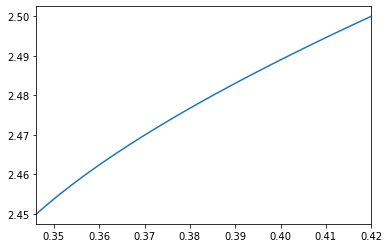

In [11]:
y = [x['exante_return'] for x in opt_list]
x = [x['exante_risk'] for x in opt_list]
pd.Series(index=x, data=y).plot()

In [12]:
from src.rbo import *

In [13]:
param['kappa'] = 1
param['estimated_alpha_cov'] = param['asset_ret_cov'] / 5
rbo = RobustMaxReturnSolver(param)
rbo.solve_without_round()



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 15              
  Cones                  : 1               
  Scalar variables       : 8               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 4
Optimizer  - Cones                  : 1
Optimizer  - Scalar variables  

{'expected_weight': A       0.831024
 B       0.168976
 cash    0.000000
 dtype: float64, 'expected_holding': A       0.831024
 B       0.168976
 cash    0.000000
 dtype: float64, 'expected_volume': A       1.0
 B       0.0
 cash    0.0
 dtype: float64, 'exante_return': 2.308643740449872, 'exante_risk': 0.390101361437834, 'exante_sr': 5.918061223730884, 'opt_status': 'optimal'}